Tasks:
1. Dataset Preparation

a. Load the dataset.

b. Create pairs of images:

i. Positive pairs: Two images belonging to the same
class.

ii. Negative pairs: Two images belonging to different
classes.

c. Create labels for each pair (1 for positive pairs, 0 for
negative pairs).

2. Network Design

a. Design a Siamese network using a shared base network (e.g.,
a simple CNN).

b. Add a distance metric (L1 distance) to compute the
similarity between feature embeddings.

c. Implement

a final decision layer for classification using a
sigmoid activation function.

3. Training the Network

a. Split the data into training and validation sets.

b. Train the Siamese network using contrastive loss.

c. Tune hyperparameters such as learning rate, batch size, and
network architecture.

4. Evaluation and Analysis

a. Evaluate the network on a separate test set by calculating
metrics such as accuracy, precision, recall, and F1 score.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import fashion_mnist
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
def make_pairs(images, labels):
    pairImages = []
    pairLabels = []
    numClasses = len(np.unique(labels))
    idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
    for idxA in range(len(images)):
        currentImage = images[idxA]
        label = labels[idxA]
        idxB = np.random.choice(idx[label])
        posImage = images[idxB]
        pairImages.append([currentImage, posImage])
        pairLabels.append([0])  # Similar pair
        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]
        pairImages.append([currentImage, negImage])
        pairLabels.append([1])  # Dissimilar pair

    return (np.array(pairImages), np.array(pairLabels))


In [3]:
def l1_distance(vects):
    x, y = vects
    return tf.math.reduce_sum(tf.abs(x - y), axis=1, keepdims=True)

def contrastive_loss(y_true, y_pred, margin=1.0):
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - y_pred, 0))
    return tf.math.reduce_mean((1 - y_true) * square_pred + y_true * margin_square)


In [9]:
def build_CNN_model(inputShape, embeddingDim=128):
    inputs = layers.Input(inputShape, name='cnn_input')
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2), name='pool_1')(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.3)(x)

    pooledOutput = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(embeddingDim, activation='relu')(pooledOutput)

    outputs = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name='l1_normalization')(outputs)
    model = Model(inputs, outputs, name='cnn_feature_extractor')
    return model

In [10]:
print("[INFO] loading Fashion MNIST dataset...")
(trainX, trainY), (testX, testY) = fashion_mnist.load_data()
trainX = trainX / 255.0
testX = testX / 255.0

trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

print("[INFO] preparing positive and negative pairs...")
(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)

IMG_SHAPE = (28, 28, 1)

print("[INFO] building siamese network...")
imgA = layers.Input(shape=IMG_SHAPE)
imgB = layers.Input(shape=IMG_SHAPE)
featureExtractor = build_CNN_model(IMG_SHAPE)

featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

distance = layers.Lambda(l1_distance)([featsA, featsB])


[INFO] loading Fashion MNIST dataset...
[INFO] preparing positive and negative pairs...
[INFO] building siamese network...


In [11]:
siamese_model_cnn = Model(inputs=[imgA, imgB], outputs=distance)

print("[INFO] compiling model...")
siamese_model_cnn.compile(
    loss=lambda y_true, y_pred: contrastive_loss(y_true, y_pred, margin=1.0),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, restore_best_weights=True)


[INFO] compiling model...


In [12]:
print("[INFO] training model...")
history = siamese_model_cnn.fit(
    [pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
    validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
    batch_size=64,
    epochs=20,
    callbacks=[earlyStopping]
)

[INFO] training model...
Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.6551 - loss: 0.2270 - val_accuracy: 0.8177 - val_loss: 0.1309
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.8171 - loss: 0.1365 - val_accuracy: 0.8382 - val_loss: 0.1187
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8341 - loss: 0.1246 - val_accuracy: 0.8469 - val_loss: 0.1122
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.8435 - loss: 0.1179 - val_accuracy: 0.8510 - val_loss: 0.1102
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8510 - loss: 0.1131 - val_accuracy: 0.8587 - val_loss: 0.1046
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.8548 - loss: 0.1108 - val_accuracy: 0.8576 - val_loss: 0.1038
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8595 - loss: 0.1070 - val_accuracy: 0.8676 - val_loss: 0.1002
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - a

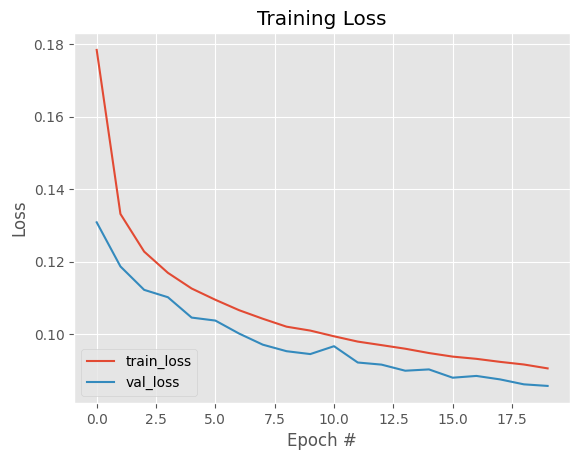

In [16]:
def plot_training(H, plotPath):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    plt.show()

plot_training(history, "training_history.png")


In [17]:
print("[INFO] evaluating the model...")
predictions = siamese_model_cnn.predict([pairTest[:, 0], pairTest[:, 1]])

[INFO] evaluating the model...
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [18]:
threshold = 0.5
predictions_binary = (predictions > threshold).astype(int)


In [19]:
accuracy = accuracy_score(labelTest, predictions_binary)
precision = precision_score(labelTest, predictions_binary)
recall = recall_score(labelTest, predictions_binary)
f1 = f1_score(labelTest, predictions_binary)


In [20]:

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.8943
Precision: 0.9269
Recall: 0.8562
F1 Score: 0.8902
